# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

You can use ** Keras ** to implement your model. Read more at [keras.io](https://keras.io/).

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0)). You are not expected to model your architecture precisely using this model nor get the same performance levels, but this is more to show an exampe of an approach used to solve this particular problem. We encourage you to try out different architectures for yourself and see what works best for you. Here is a useful [forum post](https://discussions.udacity.com/t/goodfellow-et-al-2013-architecture/202363) discussing the architecture as described in the paper and here is [another one](https://discussions.udacity.com/t/what-loss-function-to-use-for-multi-digit-svhn-training/176897) discussing the loss function.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.random.seed(41)
### Your code implementation goes here.
### Feel free to use as many code cells as needed.


Using TensorFlow backend.


4


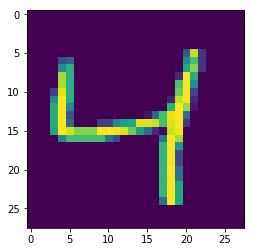

In [13]:
from keras.datasets import mnist
(image_train, label_train), (image_test, label_test)  =mnist.load_data()
plt.figure()
plt.imshow(image_train[2, :, :])
print label_train[2]

In [3]:
print label_train.shape

(60000,)


In [4]:
print image_train.shape[0]
print image_test.shape[0]

60000
10000


In [15]:
"""Generate sequence images by concatenating 5 numbers and provides labels for those sequences"""
def im_merge(im_in, label_in, num_out, max_num):
    data = np.ndarray(shape=(num_out,28,140))
    labels = np.ndarray(shape=(num_out,6))
    for ctr in range(0,num_out):
        im_list = []
        label_list=[]
        arr_len = im_in.shape[0]
        num_dig = np.random.randint(3,max_num+1)
        for itr in range(0,num_dig):
            index = np.random.randint(0,arr_len)
            im_list.append(im_in[index,:,:])
            label_list.append(label_in[index])
        concat = np.concatenate(im_list, axis=1)
        full_im = np.zeros((28,140))
        full_im[:,0:28*num_dig] += concat
        data[ctr]= full_im
        full_label = np.empty(6)
        full_label.fill(10)
        full_label[0:num_dig] = label_list
        full_label[5]=num_dig
        labels[ctr] = full_label
    return data , labels

[  0.   9.   6.   4.  10.   4.]


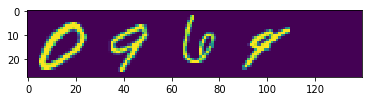

In [16]:
num_train = 20000
num_test = 2000
max_num = 5
train_data, label_train = im_merge(image_train, label_train, num_train, max_num)
test_data, label_test = im_merge(image_test, label_test, num_test, max_num)
plt.figure()
plt.imshow(train_data[2])
print label_train[2]
train_data = train_data/255
test_data = test_data/255
train_data = train_data.reshape(train_data.shape[0],1,train_data.shape[1],train_data.shape[2])
test_data = test_data.reshape(test_data.shape[0],1,test_data.shape[1],test_data.shape[2]).astype('float32')


In [7]:
print train_data.shape

(20000, 1, 28, 140)


In [18]:
from keras.utils import np_utils
hot_train = np.zeros((num_train,max_num+1,11))
hot_test = np.zeros((num_test,max_num+1,11))
for digit in range(0,len(label_train[0])):
    hot_train[:,digit,:] = np_utils.to_categorical(label_train[:,digit],11)
    hot_test[:,digit,:] = np_utils.to_categorical(label_test[:,digit],11)
print label_train[2],hot_train[2]

[  0.   9.   6.   4.  10.   4.] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]]


In [29]:
train_label_list = []
test_label_list = []
for itr in range(0,6):
    train_label_list.append(hot_train[:,itr,:])
    test_label_list.append(hot_test[:,itr,:])


In [20]:
from keras.models import Model
from keras.layers import Dense, Input, merge, Convolution2D, MaxPooling2D
from keras.layers import Dropout, Flatten

In [31]:
def large_cnn(num_outs):
    input_img=Input(shape=(1,28,140))
    con1 = Convolution2D(30, 5, 5, border_mode='valid', activation='relu', dim_ordering="th")(input_img)
    pool1 = MaxPooling2D(pool_size=(2, 2), dim_ordering="th")(con1)
    con2 = Convolution2D(15, 3, 3, border_mode='valid', activation='relu', dim_ordering="th")(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2), dim_ordering="th")(con2)
    drop1 = Dropout(0.4)(pool2)
    flat = Flatten()(drop1)
    den1 = Dense(128, activation='relu')(flat)
    den2 = Dense(128, activation='relu')(den1)
    drop2 = Dropout(0.4)(den2)
    outputs = []
    for itr in range(0,num_outs):
        outputs.append(Dense(11, activation='softmax')(drop2))
    model = Model(input=input_img, output=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [30]:
# build the model
conv_net = large_cnn(6)
# Fit the model
conv_net.fit(train_data, train_label_list, nb_epoch=10, batch_size=200, verbose=1, validation_split=.2)
# Final evaluation of the model
predictions = conv_net.predict(test_data,batch_size=200, verbose=1)
combined_pred = np.array(predictions).argmax(axis=2).T
equiv = combined_pred==label_test
print 'digit acc' , float(np.sum(equiv))/10000
seq_acc = np.sum((equiv.sum(axis=1)==5))/2000.0
print 'sequence acc' , seq_acc

Train on 16000 samples, validate on 4000 samples
Epoch 1/10
16000/16000 [==============================] - 607s - loss: 7.5575 - dense_26_loss: 1.6894 - dense_27_loss: 1.7233 - dense_28_loss: 1.7090 - dense_29_loss: 1.3719 - dense_30_loss: 0.8404 - dense_31_loss: 0.2236 - dense_26_acc: 0.4061 - dense_27_acc: 0.3980 - dense_28_acc: 0.4101 - dense_29_acc: 0.5326 - dense_30_acc: 0.7313 - dense_31_acc: 0.9469 - val_loss: 3.2090 - val_dense_26_loss: 0.6040 - val_dense_27_loss: 0.7203 - val_dense_28_loss: 0.7732 - val_dense_29_loss: 0.6304 - val_dense_30_loss: 0.4678 - val_dense_31_loss: 0.0132 - val_dense_26_acc: 0.8238 - val_dense_27_acc: 0.7695 - val_dense_28_acc: 0.7510 - val_dense_29_acc: 0.7915 - val_dense_30_acc: 0.8455 - val_dense_31_acc: 0.9965

KeyboardInterrupt: 

Current Best Digit ACC 0.9789, Sequence ACC .901

In [ ]:
print model

### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** 

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

In [12]:
def base_mod(num_outs):
    inputs=Input(shape=(3920,))
    x = Dense(3920, activation='relu')(inputs)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    outputs = []
    for itr in range(0,num_outs):
        outputs.append(Dense(11, activation='softmax')(x))
    model = Model(input=inputs, output=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [21]:
def inception(num_outs):
    input_img=Input(shape=(1,28,140))
    tower_1 = Convolution2D(64, 1, 1, border_mode='same', activation='relu')(input_img)
    tower_1 = Convolution2D(64, 3, 3, border_mode='same', activation='relu')(tower_1)

    tower_2 = Convolution2D(64, 1, 1, border_mode='same', activation='relu')(input_img)
    tower_2 = Convolution2D(64, 5, 5, border_mode='same', activation='relu')(tower_2)

    tower_3 = MaxPooling2D((3, 3), strides=(1, 1), border_mode='same')(input_img)
    tower_3 = Convolution2D(64, 1, 1, border_mode='same', activation='relu')(tower_3)

    merged = merge([tower_1, tower_2, tower_3], mode='concat', concat_axis=1)
    
    flat = Flatten()(merged)
    drop = Dropout(0.3)(flat)
    next_rel = Dense(128,activation='relu')(drop)
    outputs = []
    for itr in range(0,num_outs):
        outputs.append(Dense(11, activation='softmax')(next_rel))
    model = Model(input=input_img, output=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [32]:
# build the model
inception = inception(5)
# Fit the model
inception.fit(train_data, train_label_list, nb_epoch=10, batch_size=200, verbose=1)
# Final evaluation of the model
predictions = inception.predict(test_data,batch_size=200, verbose=1)
combined_pred = np.array(predictions).argmax(axis=2).T
print float(np.sum(combined_pred==label_test))/10000

0.9354


In [12]:
def monster(num_outs):
    input_img=Input(shape=(1,28,140))
    tower_1 = Convolution2D(64, 1, 1, border_mode='same', activation='relu')(input_img)
    tower_1 = Convolution2D(64, 3, 3, border_mode='same', activation='relu')(tower_1)

    tower_2 = Convolution2D(64, 1, 1, border_mode='same', activation='relu')(input_img)
    tower_2 = Convolution2D(64, 5, 5, border_mode='same', activation='relu')(tower_2)

    tower_3 = MaxPooling2D((3, 3), strides=(1, 1), border_mode='same')(input_img)
    tower_3 = Convolution2D(64, 1, 1, border_mode='same', activation='relu')(tower_3)

    merged = merge([tower_1, tower_2, tower_3], mode='concat', concat_axis=1)
    con1 = Convolution2D(30, 5, 5, border_mode='valid', activation='relu', dim_ordering="th")(merged)
    pool1 = MaxPooling2D(pool_size=(2, 2), dim_ordering="th")(con1)
    con2 = Convolution2D(15, 3, 3, border_mode='valid', activation='relu', dim_ordering="th")(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2), dim_ordering="th")(con2)
    drop = Dropout(0.2)(pool2)
    flat = Flatten()(drop)
    den1 = Dense(128, activation='relu')(flat)
    den2 = Dense(128, activation='relu')(den1)
    outputs = []
    for itr in range(0,num_outs):
        outputs.append(Dense(11, activation='softmax')(den2))
    model = Model(input=input_img, output=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

**Answer:**

In [13]:
# build the reall big model
model = monster(5)
# Fit the model
model.fit(train_data, train_list, nb_epoch=10, batch_size=200, verbose=1)
# Evaluate the model
predictions = model.predict(test_data,batch_size=200, verbose=1)
combined_pred = np.array(predictions).argmax(axis=2).T
equiv = combined_pred==label_test
print float(np.sum(equiv))/10000
seq_acc = np.sum((equiv.sum(axis=1)==5))/2000.0
print seq_acc

0.9199
0.6605
